# Program

In this notebook we analyze floorplan from a programmatic perspective. Our goal being to be able to find ideal matches for a given floorplan with respect to its program, we build two ratios of similarity, that we combine later to get our best matches.

- **Similarity Ratio** (Ratio 1): given plan A and plan B, the similarity ratio is a percentage of plan A's program that can be found in plan B. (Value between 0 and 1 | Most similar as the ratio converges towards 1)
- **Remainder Ratio** (Ratio 2): The Remainder ratio is the ratio of room from plan B not present in plan A, to the number of room in plan B. In other words, it weights how "dissimilar" plan B is form plan A. (Value between 0 and 1 | Plan most similar as the ratio converges towards 0)

To find ideal match we minimize **ratio_1 - ratio_2 - 1**. As a result, we obtain similar building, having similar program and a close enough number of rooms.

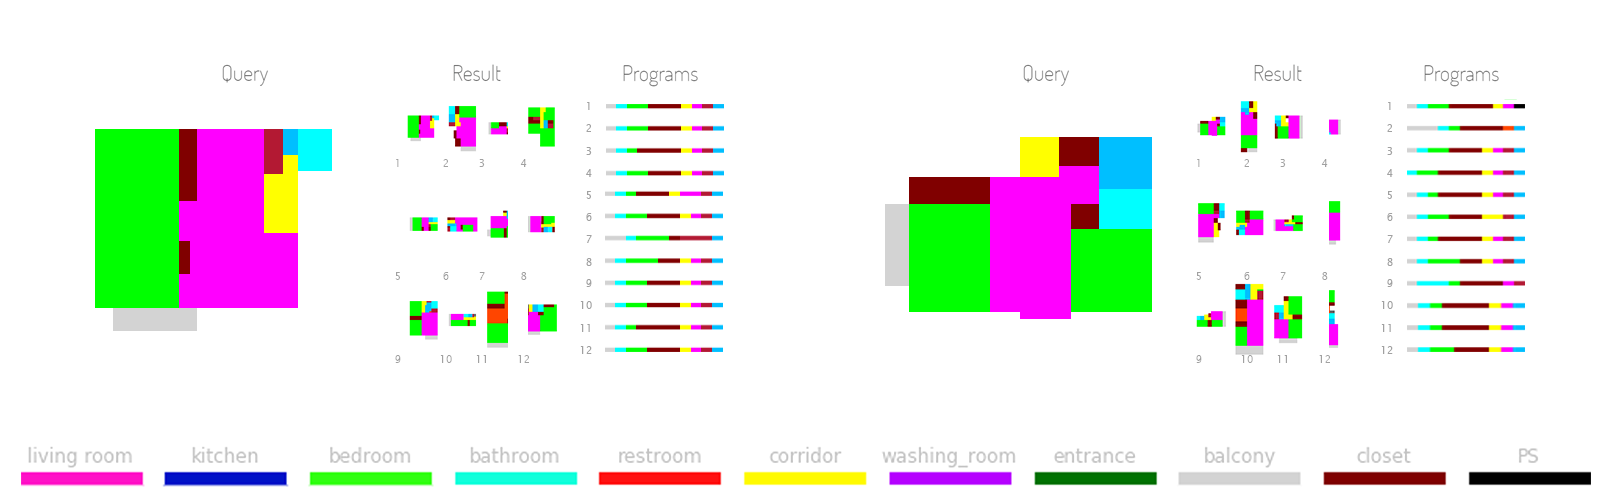

In [2]:
from IPython.display import Image
Image(filename='IMG/query.png',width=1200, height=300)

In [120]:
import pandas as pd
import cairo
import matplotlib.pylab as plt
import math
from IPython.display import Image
import numpy as np
import glob
import os
import os.path
import time
import cv2
import random
import ast
from shapely.geometry import LineString
import shapely
from graphviz import *
import networkx as nx
import scipy as sc
from IPython.display import Javascript
import json
import sys
from collections import Counter

from numpy import *
from PIL import Image
from math import *
from scipy.ndimage.interpolation import geometric_transform
from scipy.spatial.distance import pdist, squareform, cdist

from skimage.morphology import skeletonize
from skimage import data
#import sknw

from shapely.geometry import LineString

In [3]:
#import data_list
data_list=pd.read_csv("../CSV/dataset_23_07.csv")
data_list.head()

,path_to_txt,corrected,rooms,plan_clean,network_corrected,rooms_img,walls_corrected
0,.\vector_graphics_floorplans\representation_pr...,corrected/1.txt,rooms/1.txt,plan_clean/1.png,network_corrected/1.png,rooms_png/1.png,walls_corrected/1.png
1,.\vector_graphics_floorplans\representation_pr...,corrected/2.txt,rooms/2.txt,plan_clean/2.png,network_corrected/2.png,rooms_png/2.png,walls_corrected/2.png
2,.\vector_graphics_floorplans\representation_pr...,corrected/4.txt,rooms/4.txt,plan_clean/4.png,network_corrected/4.png,rooms_png/4.png,walls_corrected/4.png
3,.\vector_graphics_floorplans\representation_pr...,corrected/5.txt,rooms/5.txt,plan_clean/5.png,network_corrected/5.png,rooms_png/5.png,walls_corrected/5.png
4,.\vector_graphics_floorplans\representation_pr...,corrected/6.txt,rooms/6.txt,plan_clean/6.png,network_corrected/6.png,rooms_png/6.png,walls_corrected/6.png


In [4]:
#draw adjacencies

def draw_plan_w_rooms(id_image,data_list, adjacencies, adj_matrix, room_labels,print_):

    #load corrected plan
    data = pd.read_csv("../../Pan DB Explorations/"+data_list.loc[id_image]["corrected"], sep="\t",header = None)
    data.columns = ["xmin", "ymin", "xmax", "ymax","category","dump1","dump2"]
    categories=['living_room','kitchen','bedroom','bathroom','restroom','balcony','washing_room',"balcony","toilet"]

    #load room dataframe
    data_rooms=pd.read_csv("../../Pan DB Explorations/"+data_list.loc[id_image]["rooms"], header=None , sep=':')
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_

    #draw rooms
    rooms_=['living_room','kitchen','bedroom','bathroom','restroom','corridor','washing_room',"entrance",'balcony','closet','PS']
    rooms_colors_=[
        #living room
        [1.000, 0.000, 1.000],
        #kitchen
        [1.000, 0.271, 0.000],
        #bedroom
        [0.000, 1.000, 0.000],
        #bathroom
        [0.000, 1.000, 1.000],
        #restroom
        [0.7,0.1,0.2],
        #corridor
        [1.000, 1.000, 0.000],
        #washing_room
        [0.000, 0.749, 1.000],
        #entrance
        [0.000, 0.000, 1.000],
        #balcony
        [0.827, 0.827, 0.827],
        #closet
        [0.502, 0.000, 0.000],
        #PS
        [0.412, 0.412, 0.412]]

    padding = 50
    stroke = 3

    xmin = np.min(data["xmin"])
    xmax = np.max(data["xmax"])
    ymin = np.min(data["ymin"]) 
    ymax = np.max(data["ymax"])

    WIDTH = int(xmax - xmin + padding)
    HEIGHT = int(ymax - ymin + padding)

    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
    ctx = cairo.Context(surface)

    cx_ = []
    cy_ = []

    cx_pt = []
    cy_pt = []
    
#SET BACKGROUND---------------

    ctx.rectangle(0.0, 0.0, WIDTH,HEIGHT)
    ctx.set_source_rgb(1, 1, 1)
    ctx.fill()

#COLOR ROOMS--------------------------------------------------------------------------------------------

    #DRAW ROOMS LIGHT GREY
    for i in range(len(data_room)):

        ctx.move_to(data_room.loc[i]["points"][0][0]+padding/2-xmin, data_room.loc[i]["points"][0][1]+padding/2-ymin)

        for j in range(len(data_room.loc[i]["points"])):

            ctx.line_to(data_room.loc[i]["points"][j][0]+padding/2-xmin, data_room.loc[i]["points"][j][1]+padding/2-ymin)

        ctx.set_source_rgb(0.85, 0.85, 0.85)
        ctx.close_path()
        ctx.fill()

#NETWORK--------------------------------------------------------------------------------------------
    #DRAW ROOM Centers
    centers = []
    contours = []
    for i in range(len(data_room)):

        contour = data_room.loc[i]["points"]
        cX = np.mean(np.array(contour)[:,0])+padding/2-xmin
        cY = np.mean(np.array(contour)[:,1])+padding/2-ymin

        centers.append([cX,cY])

        ctx.arc(cX, cY, 4, 0, 2*math.pi)
        ctx.set_source_rgb(1, 0, 0)
        ctx.fill()

    #DRAW LINK LINES
    for i in range(len(adjacencies)):
        #for j in range(len(centers)):
        ctx.move_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][0]][0], centers[adjacencies[i][0]][1])
        ctx.line_to(centers[adjacencies[i][1]][0], centers[adjacencies[i][1]][1])
        ctx.close_path()
        ctx.set_source_rgba(1, 0, 0,0.2)
        ctx.set_line_width(1)
        ctx.stroke()

#WALLS & OPENING-----------------------------------------------------------------------------
#DRAW WALLS
    for i in range(len(data)):
        if(data.loc[i]["category"]=="wall"):
            ctx.move_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmin"]+padding/2-xmin, data.loc[i]["ymin"]+padding/2-ymin)
            ctx.line_to(data.loc[i]["xmax"]+padding/2-xmin, data.loc[i]["ymax"]+padding/2-ymin)
            ctx.close_path() 
            ctx.set_source_rgb(0,0,0)
            ctx.set_line_width(3)
            ctx.set_line_cap(cairo.LINE_CAP_SQUARE)
            ctx.stroke()

    surface.write_to_png("IMG/room_print/"+str(id_image)+".png") 
    img_ = cv2.cvtColor(cv2.imread("IMG/room_print/"+str(id_image)+".png"),cv2.COLOR_BGR2RGB)
    
    room_labels_ = []
    for label in room_labels:
        room_labels_.append(label[0])
    
    fig = plt.figure(figsize=(20, 6))
    
    if(print_==True):

        ax1 = fig.add_subplot(131)
        ax1.imshow(img_)
        ax1.axis("off")

        ax2 = fig.add_subplot(132)
        ax2.set_yticks(range(len(room_labels_)))
        ax2.set_yticklabels([str(room_labels_[x]) for x in range(len(room_labels_))], rotation=45)

        ax2.set_xticks(range(len(room_labels_)))
        ax2.set_xticklabels([str(room_labels_[x]) for x in range(len(room_labels_))], rotation=45)

        ax2.imshow(adj_matrix,cmap="Greys")

        ax2.set_title("Adjacency Matrix")
    else:
        plt.close()
    
    
    #Intialize Graph
    #graph = Digraph(comment='Floor Plan', format='png')
    graph = nx.Graph(comment='Floor Plan', format='png')
    #graph.attr(rankdir='LR', size='15,5')

    #Append rooms as nodes
    for i in range(len(room_labels)):
        graph.add_node(str(i),label = room_labels[i][0].upper())

    #Append connections as edges
    for i in range(len(adjacencies)):
        graph.add_edge(str(adjacencies[i][0]),str(adjacencies[i][1]))
    
    # draw networkX
    #nx.draw(graph)
    #nx.nx_agraph.to_agraph(graph)
    
    #graph.render('IMG/graphs_/graph_'+str(id_image), view=False)
    #graph.render('IMG/graphs/graph_1', view=False)
    
    if(print_==True):
    
        #plt.rcParams['figure.dpi']= 200

        ax3 = fig.add_subplot(133)
        #ax3.set_rcParams['figure.dpi']= 200
        ax3.imshow(cv2.imread('IMG/graphs/graph_1.png'), interpolation='none')
        ax3.axis('off')

        plt.show()
    
    return fig,graph

In [5]:
def get_points(data_rooms):
    # Get Points
    rooms_ = []
    points_ = []
    for i in range(len(data_rooms)):
        a = data_rooms.loc[i].values
        try:
            points = ast.literal_eval(a[1])
        except:
            points = [[0.0,0.0]]
        points_.append(points)
        try:
            rooms = a[0].split(",")
        except:
            rooms = "NaN"
        rooms_.append(rooms)
    data_room = pd.DataFrame()
    data_room["rooms"] = rooms_
    data_room["points"] = points_
    
    PTS = []
    
    for i in range(len(points_)):
        PTS.append(list(points_[i]))
    
    return PTS, rooms_

## 1/ Get Graphs

In [6]:
#draw rooms
rooms_=['living_room','kitchen','bedroom','bathroom','restroom','corridor','washing_room',"entrance",'balcony','closet','PS']
rooms_colors_=[
    #living room
    [1.000, 0.000, 1.000],
    #kitchen
    [1.000, 0.271, 0.000],
    #bedroom
    [0.000, 1.000, 0.000],
    #bathroom
    [0.000, 1.000, 1.000],
    #restroom
    [0.7,0.1,0.2],
    #corridor
    [1.000, 1.000, 0.000],
    #washing_room
    [0.000, 0.749, 1.000],
    #entrance
    [0.000, 0.000, 1.000],
    #balcony
    [0.827, 0.827, 0.827],
    #closet
    [0.502, 0.000, 0.000],
    #PS
    [0.412, 0.412, 0.412]]

In [7]:
graphs = np.load("graphs/graphs.npy")

In [8]:
def get_adj_and_prgm(i,graphs):
    
    #for a given plan
    room_list = nx.get_node_attributes(graphs[i], 'label')

    program = list(np.array(list(room_list.items()))[:,1])
    print(program)

    #get adjacencies
    edges = np.array(list(graphs[i].edges))
    adjs = []

    for edge in edges:
        adj = [room_list[edge[0]],room_list[edge[1]]]
        adjs.append(adj)
        
    return adjs,program

In [ ]:
adj = []
prgms = []

for i in range(len(graphs)):
    adj_, prgm_ = get_adj_and_prgm(i,graphs)
    adj.append(adj)
    prgms.append(prgm_)

## 2/ Program Comparison to Matrix

In [281]:
color_dict = dict(zip(rooms_,rooms_colors_))
color_dict['n']=[0,0,0]
color_dict['stairs']=[0,0,0]
color_dict['ps']=[0,0,0]

In [158]:
def compare_pgm(list1,list2):
    
    set_list2 = set(list2)
    list2_in_list1 = [x for x in list1 if x in set_list2]
    count = Counter(list2_in_list1)
    values_in_1_being_in_2 = np.sum(list(count.values()))
    
    #COMPLETION: How many items from list 1 can be found in list 2
    ratio_1 = values_in_1_being_in_2/len(list1)
    
    #REMAINDER
    ratio_2 = np.abs(values_in_1_being_in_2-len(list2))/len(list2)
    
    return ratio_1,ratio_2

In [ ]:
ratio_1_matrix = np.zeros((1000,1000))
ratio_2_matrix = np.zeros((1000,1000))

for i in range(1000):
    for j in range(1000):
        
        #PLAN 1
        #adjacency_1 = adj[j]
        program_1 = prgms[j]
        
        #PLAN 2
        #adjacency_2 = adj[i]
        program_2 = prgms[i]
        
        #compare PGM
        ratio_1,ratio_2 = compare_pgm(program_1,program_2)
        
        ratio_1_matrix[i,j] = ratio_1
        ratio_2_matrix[i,j] = ratio_2

#### Ratio 1 Matrix

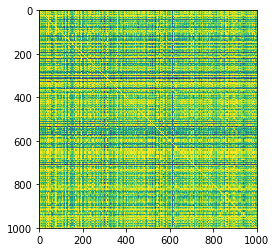

In [162]:
plt.imshow(ratio_1_matrix)

#### Ratio 2 Matrix

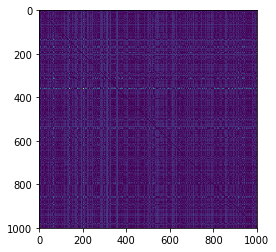

In [161]:
plt.imshow(ratio_2_matrix)

In [163]:
np.save( "../matrix/sim_matrix_pgm_1",ratio_1_matrix)
np.save( "../matrix/sim_matrix_pgm_2",ratio_2_matrix)

In [164]:
sim_matrix_pgm_1 = np.load("../matrix/sim_matrix_pgm_1.npy")
sim_matrix_pgm_2 = np.load("../matrix/sim_matrix_pgm_2.npy")

## 3/ Display Matches

In [326]:
def pgm_color_vector(i,program, print_):
    
    program = np.sort(program)
    
    #pgrm to color vector
    pg_colors =  [color_dict[j.lower()] for j in program]

    image = np.array(pg_colors).reshape(len(pg_colors),1,3)
        
    fig, ax = plt.subplots(figsize=(3,4))

    ax1 = fig.add_subplot(211)
    ax1.imshow(cv2.cvtColor(cv2.imread("IMG/program/"+str(i)+".png",cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    return ax

In [356]:
def print_matches(nb_neighbors,plan_id,sim_matrix_1,sim_matrix_2):
    
    #ids = np.argsort(sim_matrix[plan_id])[0:nb_neighbors]
    sim_matrix = np.abs(sim_matrix_1-sim_matrix_2-1)
    ids = np.argsort(sim_matrix[plan_id])[0:nb_neighbors]
    
    path_to_folder = "IMG/program/"
    
    plt.imshow(cv2.cvtColor(cv2.imread(path_to_folder+str(plan_id)+".png",cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
    #cv2.cvtColor(cv2.imread(path_to_folder+str(plan_id)+".png",cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title("ID: "+str(plan_id))
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    
    width = 20
    height= int(np.floor(len(ids)/width)+1)
    
    for i in range(len(ids)):
        
        plt.subplot(height, width, i+1)
        plt.imshow(cv2.cvtColor(cv2.imread(path_to_folder+str(ids[i])+".png",cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB))
        plt.axis("off")
        
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    
    width = 20
    height= int(np.floor(len(ids)/width)+1)
    for i in range(len(ids)):   
        #get pgrm of plan
        program = np.sort(prgms[ids[i]])
        #pgrm to color vector
        pg_colors =  [color_dict[j.lower()] for j in program]
        image = np.array(pg_colors).reshape(len(pg_colors),1,3)
        
        plt.subplot(height, width, i+1)
        plt.axis("off")
        plt.imshow(image)
        
    plt.show()

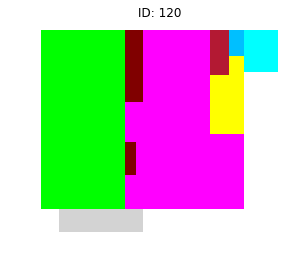

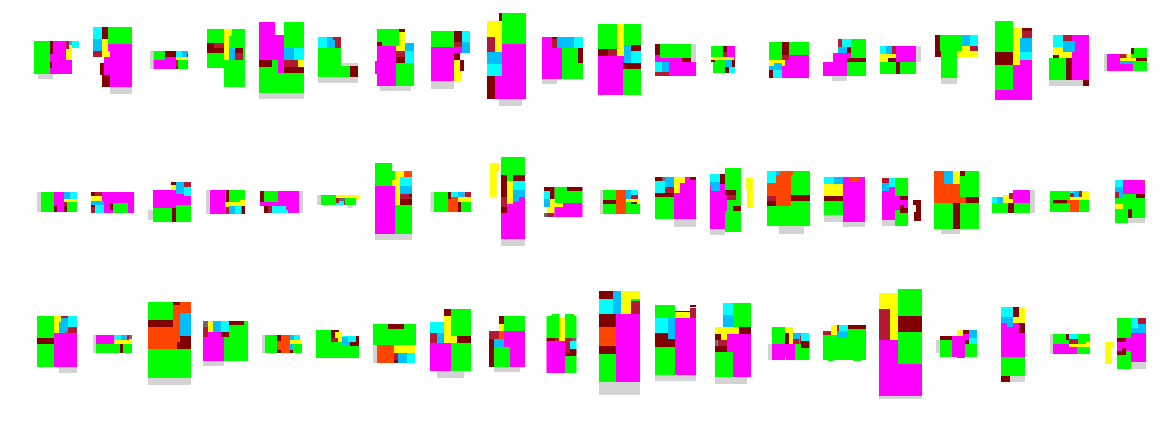

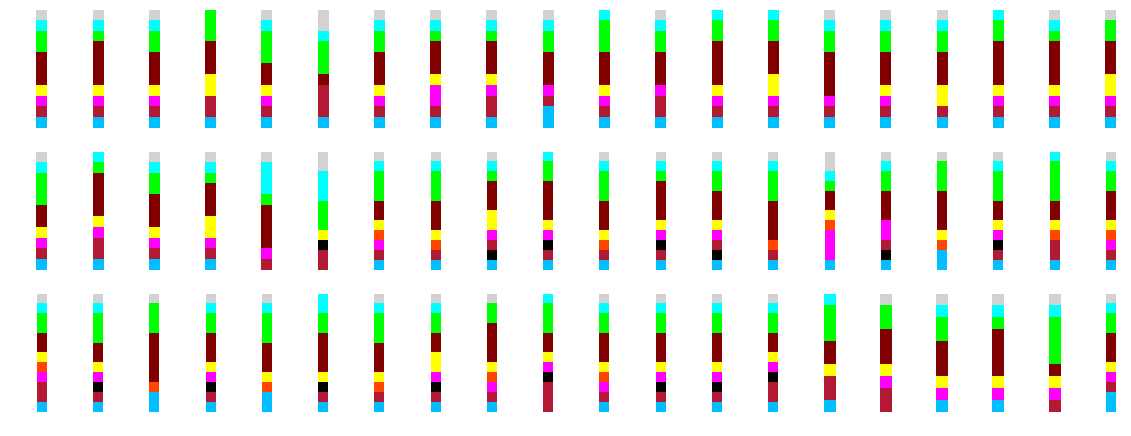

In [357]:
#nb of items
plan_id = 120
nb_neighbors = 60
print_matches(nb_neighbors,plan_id,sim_matrix_pgm_1,sim_matrix_pgm_2)

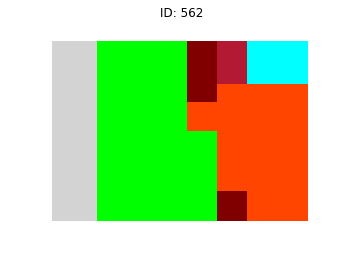

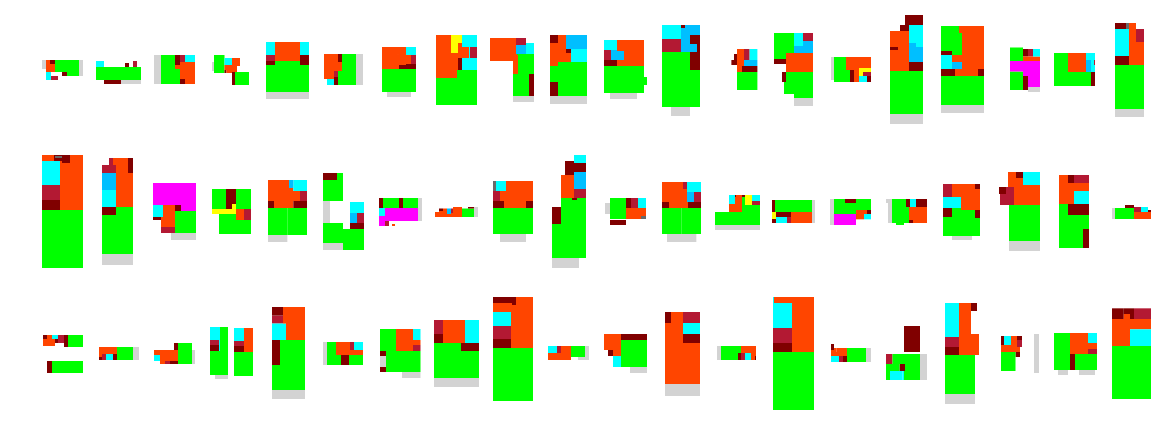

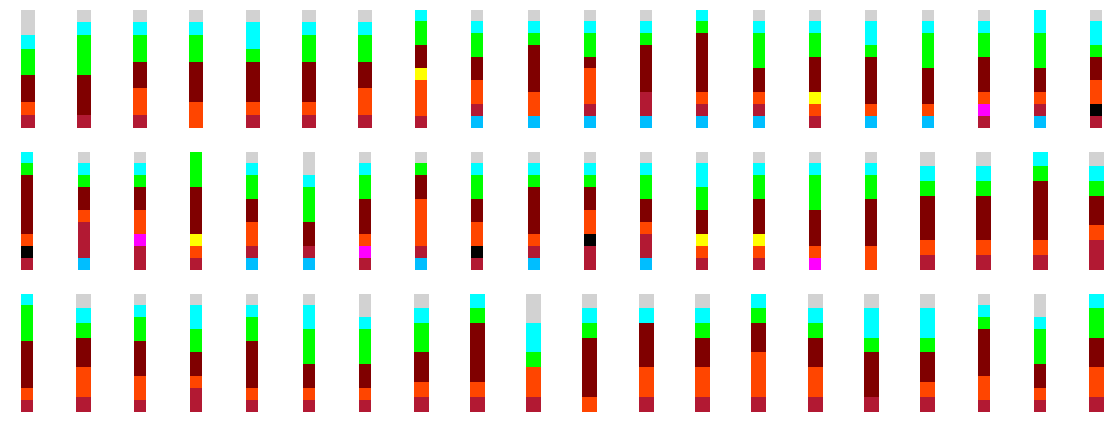

In [373]:
plan_id = 562
nb_neighbors = 60
print_matches(nb_neighbors,plan_id,sim_matrix_pgm_1,sim_matrix_pgm_2)

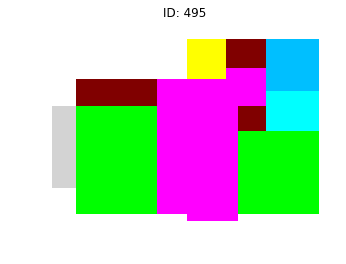

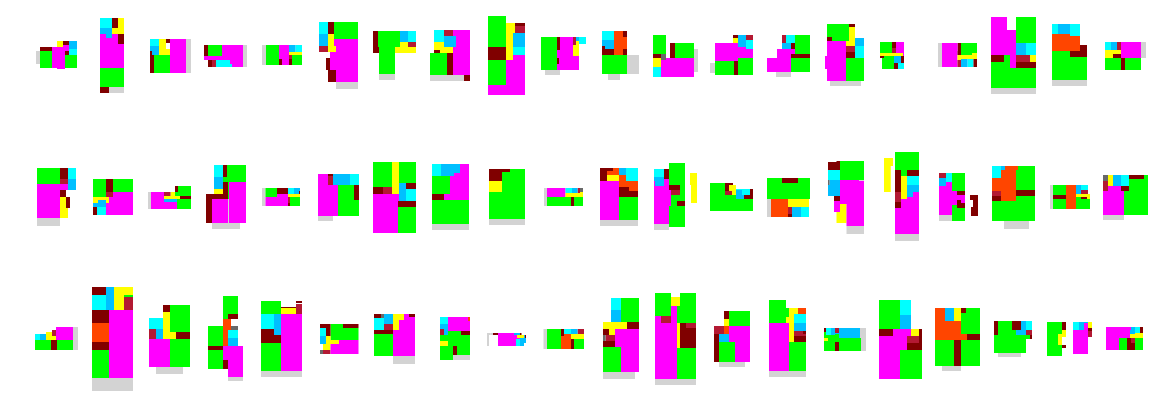

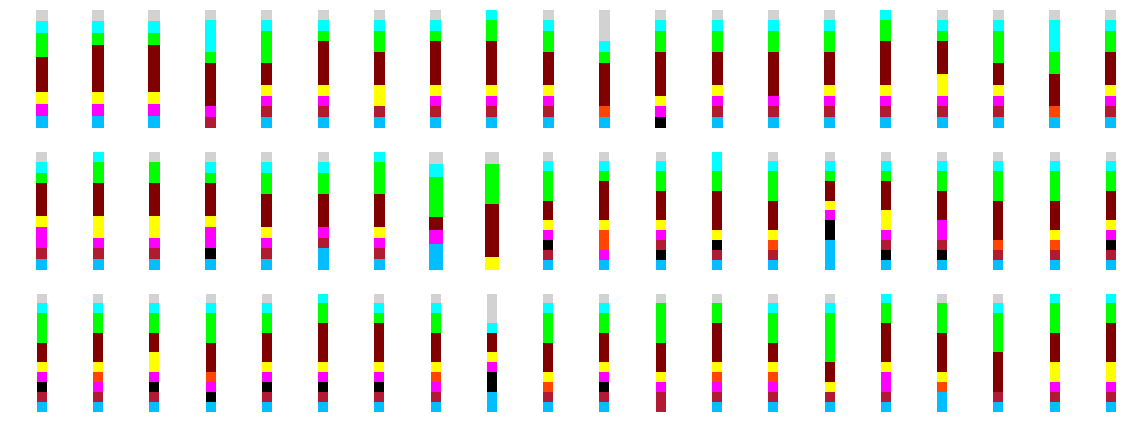

In [371]:
plan_id = 495
nb_neighbors = 60
print_matches(nb_neighbors,plan_id,sim_matrix_pgm_1,sim_matrix_pgm_2)

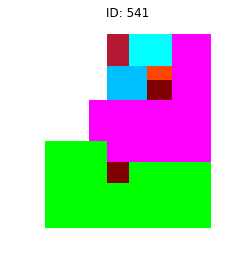

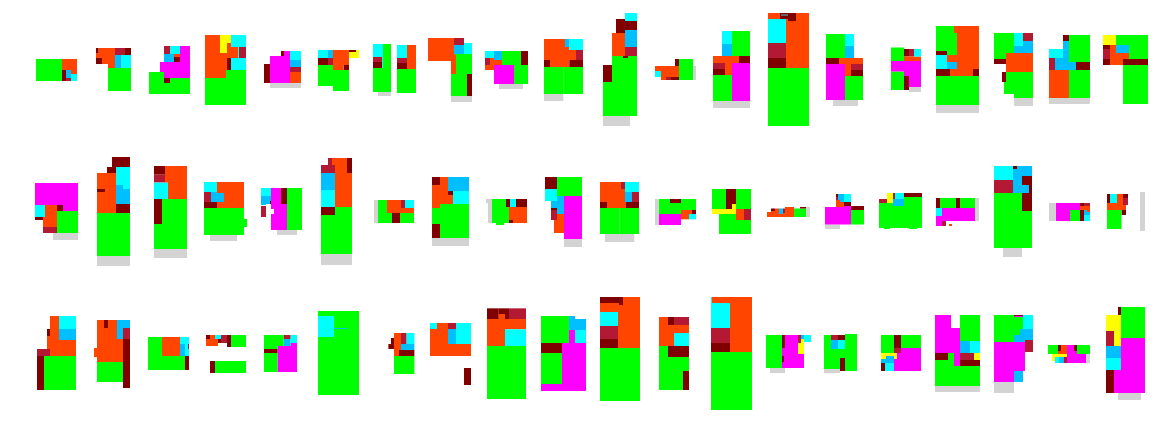

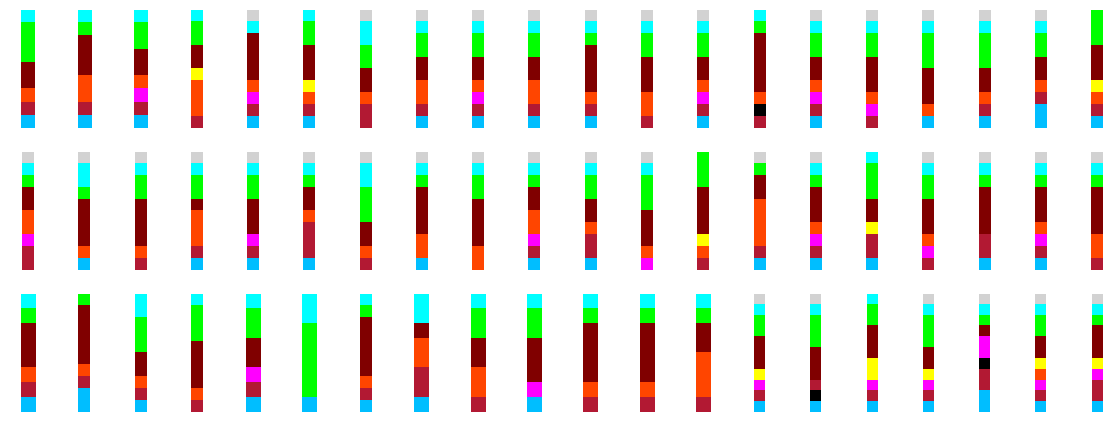

In [375]:
plan_id = 541
nb_neighbors = 60
print_matches(nb_neighbors,plan_id,sim_matrix_pgm_1,sim_matrix_pgm_2)